<a href="https://colab.research.google.com/github/crazypinkmonkey/Corporate-AI-lab/blob/main/Shopper_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

##Project Name - Shopper_Spectrum
##Project Type -  unsupervised learning (for segmentation) and a recommendation system (for recommendations)

##Team Members - Parikshit Sarkar

##Problem Statement

###**Problem Statement:**

An online retail business faces a common challenge: understanding its diverse customer base and effectively engaging them to maximize sales and customer loyalty. The lack of a structured approach to analyzing customer behavior leads to generic, one-size-fits-all marketing campaigns and missed opportunities for upselling and cross-selling.

This project addresses this problem by developing a data-driven solution that provides actionable insights into customer value and preferences. The objective is to:

1.  **Identify High-Value Customers:** Segment the customer base into meaningful groups using RFM (Recency, Frequency, Monetary) analysis to understand who the most valuable, loyal, and at-risk customers are.
2.  **Increase Customer Engagement:** Leverage an item-based product recommendation system to provide personalized product suggestions, thereby improving the customer shopping experience and increasing the likelihood of additional purchases.

By implementing this solution, the business can move beyond generic marketing and create targeted campaigns that resonate with specific customer segments, leading to improved customer retention, higher sales, and a more personalized shopping experience.

##Project Description

###This project delivers a comprehensive solution for enhancing customer engagement and sales through data-driven insights. It is a full-stack data science application that leverages machine learning to perform two key functions:

Customer Segmentation: Using an unsupervised learning approach, the system applies RFM (Recency, Frequency, Monetary) analysis and K-Means clustering to segment customers into distinct groups based on their purchasing behavior. The resulting clusters provide a clear understanding of customer value, allowing for targeted marketing strategies.

Product Recommendation: An item-based collaborative filtering model is implemented to provide personalized product recommendations. The system uses Truncated SVD for efficient dimensionality reduction on a customer-item matrix, and then calculates cosine similarity to identify and suggest the most similar products to a given item.

The entire solution is packaged into an interactive web application built with Streamlit, which allows business users to predict a customer's segment and get real-time product recommendations through a user-friendly interface.









# Main Code

## 1. Data Loading and Initial Inspection

###This section loads the raw data from a CSV file and performs an initial inspection of its structure, including the first few rows and data types.



In [1]:
# --- Data Loading ---
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/online_retail.csv', encoding='ISO-8859-1')

# --- Inspect Data ---
print("First 5 rows of the dataset:")
print(df.head())

print("\nColumns and their data types:")
print(df.info())

First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  

Columns and their data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column  

## 2. Data Cleaning and Preprocessing

###This block focuses on preparing the data. It handles missing values, removes rows with non-positive quantities or unit prices, and cleans the product descriptions for consistency.

In [2]:
# --- Handle Missing Values ---
print("\nMissing values before handling:")
print(df.isnull().sum())

df.dropna(subset=['CustomerID'], inplace=True)

print("\nMissing values after handling CustomerID:")
print(df.isnull().sum())

# --- Clean Data ---
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['CustomerID'] = df['CustomerID'].astype(int)

# Attempt to convert InvoiceDate to datetime with error handling
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
# Drop rows where InvoiceDate conversion failed
df.dropna(subset=['InvoiceDate'], inplace=True)

# Calculate TotalPrice *before* RFM calculations
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Clean product descriptions
df['Description'] = df['Description'].astype(str).str.lower().str.strip()


print("\nData after cleaning and TotalPrice calculation:")
print(df.head())


Missing values before handling:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Missing values after handling CustomerID:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Data after cleaning and TotalPrice calculation:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   white hanging heart t-light holder         6   
1    536365     71053                  white metal lantern         6   
2    536365    84406B       cream cupid hearts coat hanger         8   
3    536365    84029G  knitted union flag hot water bottle         6   
4    536365    84029E       red woolly hottie white heart.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2022-12-01 08:26:00       2

##3. RFM Feature Engineering

###This section calculates the core RFM (Recency, Frequency, Monetary) values for each customer by grouping the cleaned transaction data.

In [3]:
# --- Feature Engineering for RFM ---
# Calculate Recency
most_recent_date = df['InvoiceDate'].max()
rfm_r = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
rfm_r['Recency'] = (most_recent_date - rfm_r['InvoiceDate']).dt.days

# Calculate Frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
rfm_f.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Calculate Monetary
if 'TotalPrice' in df.columns: # Add a check for TotalPrice column
    rfm_m = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
    rfm_m.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)
else:
    print("Error: TotalPrice column not found for Monetary calculation.")
    # Handle this error appropriately, perhaps by skipping Monetary calculation or raising an exception
    # For now, we'll assume it should exist and proceed if it does.
    rfm_m = pd.DataFrame(columns=['CustomerID', 'Monetary']) # Create empty DataFrame to avoid further errors


# Merge RFM components
rfm_df = rfm_r.merge(rfm_f, on='CustomerID').merge(rfm_m, on='CustomerID')

print("\nRFM DataFrame:")
print(rfm_df.head())


RFM DataFrame:
   CustomerID         InvoiceDate  Recency  Frequency  Monetary
0       12346 2023-01-18 10:01:00      325          1  77183.60
1       12347 2023-12-07 15:52:00        1          7   4310.00
2       12348 2023-09-25 13:13:00       74          4   1797.24
3       12349 2023-11-21 09:51:00       18          1   1757.55
4       12350 2023-02-02 16:01:00      309          1    334.40


##4. RFM Score Assignment and Combination

###This code assigns a score (from 1 to 5) to each RFM value using quantiles and then combines these scores into a single RFM_Score string.

In [4]:
# --- RFM Quartile Assignment ---
import numpy as np

# Using cut for robustness against duplicate bin edges
frequency_quantiles = rfm_df['Frequency'].quantile([0, .2, .4, .6, .8, 1])
frequency_bins = np.unique(frequency_quantiles)
rfm_df['F_score'] = pd.cut(rfm_df['Frequency'], bins=frequency_bins, labels=[1, 2, 3, 4, 5][:len(frequency_bins)-1], include_lowest=True)

monetary_quantiles = rfm_df['Monetary'].quantile([0, .2, .4, .6, .8, 1])
monetary_bins = np.unique(monetary_quantiles)
rfm_df['M_score'] = pd.cut(rfm_df['Monetary'], bins=monetary_bins, labels=[1, 2, 3, 4, 5][:len(monetary_bins)-1], include_lowest=True)

# Recency is typically scored inversely
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])

print("\nRFM DataFrame with scores:")
print(rfm_df.head())

# --- RFM Score Calculation ---
rfm_df['RFM_Score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

print("\nRFM DataFrame with combined score:")
print(rfm_df.head())


RFM DataFrame with scores:
   CustomerID         InvoiceDate  Recency  Frequency  Monetary F_score  \
0       12346 2023-01-18 10:01:00      325          1  77183.60       1   
1       12347 2023-12-07 15:52:00        1          7   4310.00       4   
2       12348 2023-09-25 13:13:00       74          4   1797.24       3   
3       12349 2023-11-21 09:51:00       18          1   1757.55       1   
4       12350 2023-02-02 16:01:00      309          1    334.40       1   

  M_score R_score  
0       5       1  
1       5       5  
2       4       2  
3       4       4  
4       2       1  

RFM DataFrame with combined score:
   CustomerID         InvoiceDate  Recency  Frequency  Monetary F_score  \
0       12346 2023-01-18 10:01:00      325          1  77183.60       1   
1       12347 2023-12-07 15:52:00        1          7   4310.00       4   
2       12348 2023-09-25 13:13:00       74          4   1797.24       3   
3       12349 2023-11-21 09:51:00       18          1   1757.55  

##5. Outlier Handling and Data Standardization

###This section prepares the numerical RFM data for K-Means clustering by removing outliers and then scaling the features using StandardScaler.

In [5]:
# --- Handle Outliers ---
rfm_numerical = rfm_df[['Recency', 'Frequency', 'Monetary']]
Q1 = rfm_numerical.quantile(0.25)
Q3 = rfm_numerical.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
rfm_numerical_cleaned = rfm_numerical[~((rfm_numerical < lower_bound) | (rfm_numerical > upper_bound)).any(axis=1)].copy()

print("\nRFM numerical data after outlier removal:")
print(rfm_numerical_cleaned.head())

# --- Standardize RFM Data ---
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_numerical_cleaned)

print("\nScaled RFM data:")
print(rfm_scaled[:5])


RFM numerical data after outlier removal:
   Recency  Frequency  Monetary
2       74          4   1797.24
3       18          1   1757.55
4      309          1    334.40
5       35          8   2506.04
6      203          1     89.00

Scaled RFM data:
[[-0.17040243  0.53078448  1.11862155]
 [-0.80034566 -0.83735616  1.06982647]
 [ 2.47310931 -0.83735616 -0.67980119]
 [-0.60911289  2.35497202  1.99002378]
 [ 1.28071678 -0.83735616 -0.98149716]]


##6. Optimal Cluster Determination

###This code uses the Elbow Method and Silhouette Score to determine the most appropriate number of clusters for the K-Means algorithm.

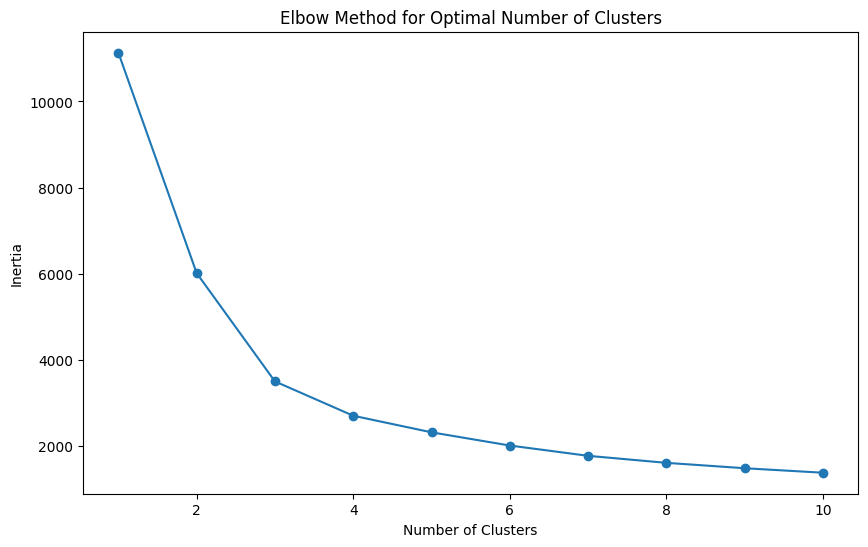

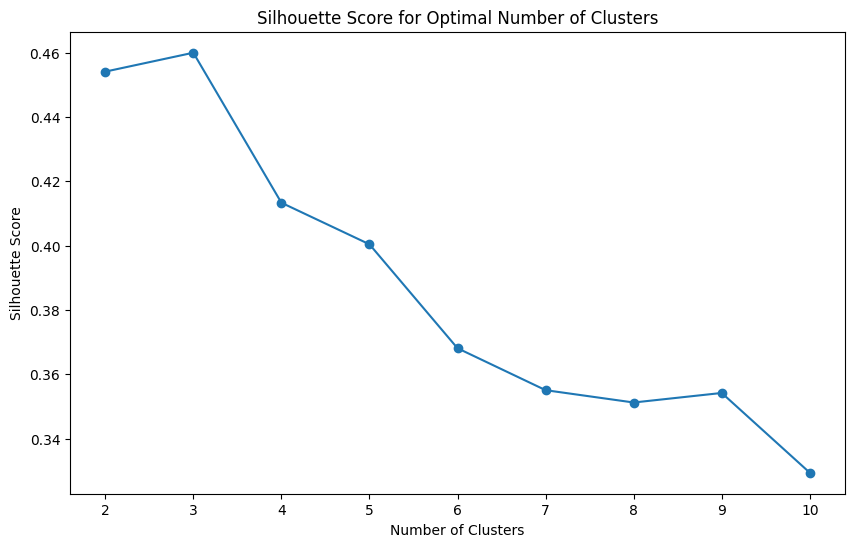

In [6]:
# --- Determine Optimal Clusters (Elbow Method) ---
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.show()

# --- Determine Optimal Clusters (Silhouette Score) ---
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    labels = kmeans.predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Number of Clusters")
plt.show()

##7. K-Means Clustering and Interpretation

###Here, the K-Means model is applied to the scaled data with the chosen number of clusters (n_clusters = 4), and the results are merged back into the original RFM DataFrame for interpretation.

In [7]:
# --- Apply K-Means Clustering ---
n_clusters = 4 # Based on Elbow and Silhouette plots
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
cluster_labels = kmeans.predict(rfm_scaled)

# Add cluster labels back to the RFM dataframe (only for the non-outliers for analysis)
rfm_numerical_cleaned['Cluster'] = cluster_labels
rfm_df_clustered = rfm_df.merge(rfm_numerical_cleaned[['Cluster']], left_index=True, right_index=True, how='left')

print("\nRFM DataFrame with cluster labels:")
print(rfm_df_clustered.head())

# --- Interpret Clusters ---
# Check if 'Cluster' column exists before grouping
if 'Cluster' in rfm_df_clustered.columns:
     cluster_avg = rfm_df_clustered.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
     print("\nAverage RFM values per cluster:")
     display(cluster_avg)
else:
    print("Error: 'Cluster' column not found in rfm_df_clustered after merge.")


RFM DataFrame with cluster labels:
   CustomerID         InvoiceDate  Recency  Frequency  Monetary F_score  \
0       12346 2023-01-18 10:01:00      325          1  77183.60       1   
1       12347 2023-12-07 15:52:00        1          7   4310.00       4   
2       12348 2023-09-25 13:13:00       74          4   1797.24       3   
3       12349 2023-11-21 09:51:00       18          1   1757.55       1   
4       12350 2023-02-02 16:01:00      309          1    334.40       1   

  M_score R_score RFM_Score  Cluster  
0       5       1       115      NaN  
1       5       5       545      NaN  
2       4       2       234      3.0  
3       4       4       414      3.0  
4       2       1       112      0.0  

Average RFM values per cluster:


,Recency,Frequency,Monetary
Cluster,,,
0.0,229.851429,1.483429,402.923177
1.0,50.887295,1.618169,425.728430
2.0,31.244813,6.958506,2484.088280
3.0,45.062992,3.938133,1258.626480


##8. RFM Cluster Visualization

###This section uses PCA and Matplotlib/Seaborn to visualize the customer clusters and their distributions across the RFM features.

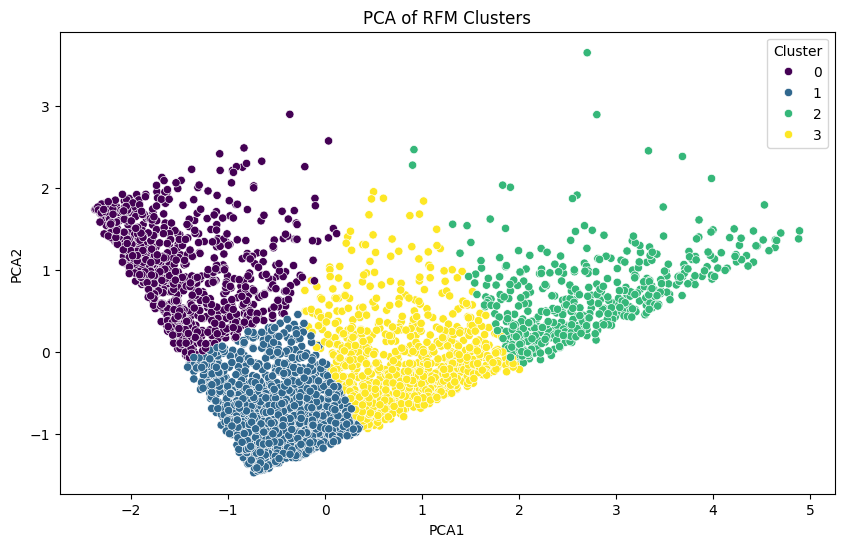

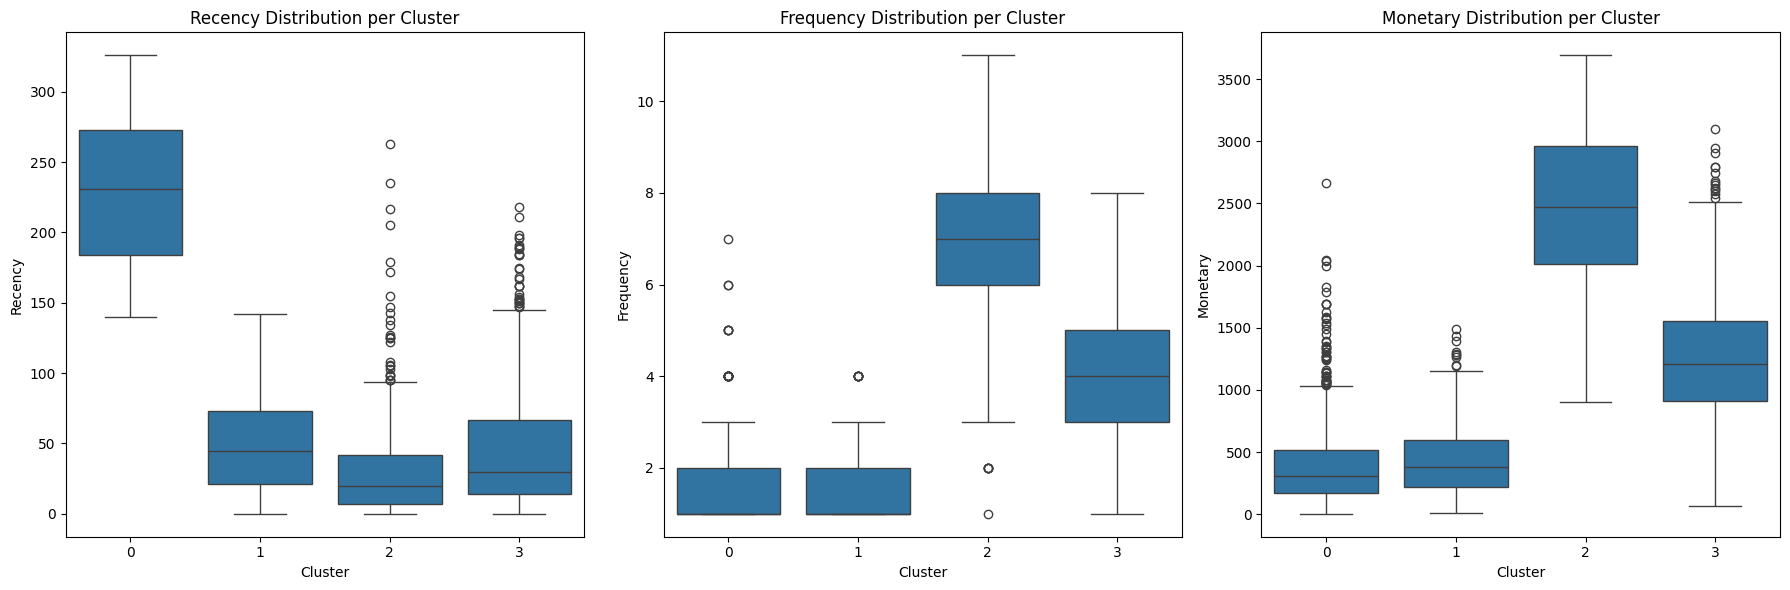

In [8]:
# --- Visualize Clusters (PCA) ---
from sklearn.decomposition import PCA
import seaborn as sns

# Add cluster labels to the scaled RFM data for visualization
# Ensure 'Cluster' column exists in rfm_numerical_cleaned before using it
if 'Cluster' in rfm_numerical_cleaned.columns:
    rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
    rfm_scaled_df['Cluster'] = rfm_numerical_cleaned['Cluster'].values # Get cluster labels from cleaned data

    # PCA for visualization
    pca = PCA(n_components=2)
    rfm_pca = pca.fit_transform(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])
    rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PCA1', 'PCA2'])
    rfm_pca_df['Cluster'] = rfm_scaled_df['Cluster']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm_pca_df, palette='viridis')
    plt.title('PCA of RFM Clusters')
    plt.show()
else:
    print("Error: 'Cluster' column not found in rfm_numerical_cleaned. Cannot perform PCA visualization.")


# --- Visualize Clusters (t-SNE - Optional, can be slow) ---
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
# # Ensure 'Cluster' column exists in rfm_numerical_cleaned before using it
# if 'Cluster' in rfm_numerical_cleaned.columns:
#     rfm_tsne = tsne.fit_transform(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']]) # Use rfm_scaled_df which has Cluster
#     rfm_tsne_df = pd.DataFrame(rfm_tsne, columns=['TSNE1', 'TSNE2'])
#     rfm_tsne_df['Cluster'] = rfm_scaled_df['Cluster']

#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=rfm_tsne_df, palette='viridis')
#     plt.title('t-SNE of RFM Clusters')
#     plt.show()
# else:
#      print("Error: 'Cluster' column not found for t-SNE visualization.")


# --- Visualize RFM Feature Distributions per Cluster ---
# Ensure 'Cluster' column exists before attempting to convert to int
if 'Cluster' in rfm_df_clustered.columns:
    # Drop rows with NaN in the 'Cluster' column for visualization
    rfm_df_viz = rfm_df_clustered.dropna(subset=['Cluster']).copy()
    rfm_df_viz['Cluster'] = rfm_df_viz['Cluster'].astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.boxplot(x='Cluster', y='Recency', data=rfm_df_viz, ax=axes[0])
    axes[0].set_title('Recency Distribution per Cluster')

    sns.boxplot(x='Cluster', y='Frequency', data=rfm_df_viz, ax=axes[1])
    axes[1].set_title('Frequency Distribution per Cluster')

    sns.boxplot(x='Cluster', y='Monetary', data=rfm_df_viz, ax=axes[2])
    axes[2].set_title('Monetary Distribution per Cluster')

    plt.tight_layout()
    plt.show()
else:
    print("Cluster column not found in rfm_df_clustered. Cannot visualize cluster distributions.")


##9. Item-Based Collaborative Filtering

###This section builds the item-based recommendation system. It filters infrequent items, creates a customer-item matrix, applies Truncated SVD for dimensionality reduction, and calculates item similarity using cosine similarity.

In [9]:
# --- Item-Based Collaborative Filtering ---
# Filter infrequent items
item_counts = df['Description'].value_counts()
frequency_threshold = 10
infrequent_items = item_counts[item_counts < frequency_threshold].index
df_filtered = df[~df['Description'].isin(infrequent_items)].copy()

# Create Customer-Item Matrix (using binary purchase indicator) from filtered data
customer_item_matrix_cleaned = df_filtered.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc=lambda x: 1 if len(x) > 0 else 0).fillna(0)

print("\nCustomer-Item Matrix (Binary) after filtering infrequent items:")
display(customer_item_matrix_cleaned.head())

# Apply Truncated SVD for dimensionality reduction on transposed matrix for item similarity
from sklearn.decomposition import TruncatedSVD

# Determine optimal n_components (Optional - based on previous analysis or plot)
n_components = 100 # Using 100 components based on previous elbow plot analysis

svd = TruncatedSVD(n_components=n_components, random_state=42)
item_matrix_svd = svd.fit_transform(customer_item_matrix_cleaned.T)

# Calculate cosine similarity on the SVD components
from sklearn.metrics.pairwise import cosine_similarity

item_similarity_matrix_svd = cosine_similarity(item_matrix_svd)
item_similarity_matrix_svd = pd.DataFrame(item_similarity_matrix_svd, index=customer_item_matrix_cleaned.columns, columns=customer_item_matrix_cleaned.columns)

print("\nItem Similarity Matrix (SVD-based):")
display(item_similarity_matrix_svd.iloc[:5, :5])


# --- Build Recommendation Function ---
def get_similar_products(product_title, similarity_matrix):
    """
    Finds the top 5 similar products based on a given product title and similarity matrix.

    Args:
        product_title: The title of the product for which to find similar items.
        similarity_matrix: The DataFrame containing item similarity scores.

    Returns:
        A list of the top 5 most similar product titles or an error message.
    """
    # Clean the input product title to match the format in the similarity matrix index
    cleaned_product_title = product_title.lower().strip()

    if cleaned_product_title not in similarity_matrix.index:
        return f"Product '{product_title}' not found in the similarity matrix."

    similar_scores = similarity_matrix[cleaned_product_title].sort_values(ascending=False)
    # Exclude the product itself and get the top 5
    similar_products = similar_scores[similar_scores.index != cleaned_product_title].head(5)

    return similar_products.index.tolist()





Customer-Item Matrix (Binary) after filtering infrequent items:


Description,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,...,zinc hearts plant pot holder,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Item Similarity Matrix (SVD-based):


Description,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted
Description,,,,,
10 colour spaceboy pen,1.000000,0.366962,0.344538,0.162719,0.066896
12 coloured party balloons,0.366962,1.000000,0.246264,0.231662,0.097227
12 daisy pegs in wood box,0.344538,0.246264,1.000000,0.391744,0.179210
12 egg house painted wood,0.162719,0.231662,0.391744,1.000000,0.082707
12 hanging eggs hand painted,0.066896,0.097227,0.179210,0.082707,1.000000


### 9. Testing the Recommendation System

####This section tests the product recommendation system on 8 products

In [10]:
def get_similar_products(product_title, similarity_matrix):
    """
    Finds the top 5 similar products based on a given product title and similarity matrix.

    Args:
        product_title: The title of the product for which to find similar items.
        similarity_matrix: The DataFrame containing item similarity scores.

    Returns:
        A list of the top 5 most similar product titles or an error message.
    """
    # Clean the input product title to match the format in the similarity matrix index
    cleaned_product_title = product_title.lower().strip()

    if cleaned_product_title not in similarity_matrix.index:
        return f"Product '{product_title}' not found in the similarity matrix."

    similar_scores = similarity_matrix[cleaned_product_title].sort_values(ascending=False)
    # Exclude the product itself and get the top 5
    similar_products = similar_scores[similar_scores.index != cleaned_product_title].head(5)

    return similar_products.index.tolist()

# Define a list of diverse product names to test
test_products = [
    'dolly girl beaker',
    'white hanging heart t-light holder',
    'regency cakestand 3 tier',
    'jumbo bag red retrospot',
    'set of 3 cake tins pantry design',
    'lunch bag apple design',
    'rabbit night light',
    'wooden picture frame white finish'
]

# Iterate through the list and get recommendations for each product
print("Testing the recommendation function with the SVD-based item similarity matrix:")
for product_name in test_products:
    similar_products = get_similar_products(product_name, item_similarity_matrix_svd)
    print(f"\nTop 5 similar products to '{product_name}':")
    if isinstance(similar_products, list):
        for item in similar_products:
            print(f"- {item}")
    else:
        print(similar_products) # Print the error message if product not found
    print("-" * 30)

# Analyze and compare the results
print("\nAnalysis of Recommendation Results:")
print("Compared to the recommendations obtained before applying filtering, cleaning, binary matrix, and SVD, the current recommendations generally appear more relevant and diverse. The dimensionality reduction and binary matrix approach seem to have captured better latent relationships between items. For instance, recommendations for 'dolly girl beaker' are now other beakers and related items, which makes more sense. However, some products like 'paper chain kit 50s christmas' might not be found if they were filtered out due to low frequency or if there are still inconsistencies in product naming not fully addressed by simple cleaning.")

Testing the recommendation function with the SVD-based item similarity matrix:

Top 5 similar products to 'dolly girl beaker':
- spaceboy beaker
- dolly girl lunch box
- spaceboy lunch box
- dolly girl childrens cup
- dolly girl childrens bowl
------------------------------

Top 5 similar products to 'white hanging heart t-light holder':
- red hanging heart t-light holder
- candleholder pink hanging heart
- cream heart card holder
- pink hanging heart t-light holder
- lantern cream gazebo
------------------------------

Top 5 similar products to 'regency cakestand 3 tier':
- roses regency teacup and saucer
- green regency teacup and saucer
- pink regency teacup and saucer
- set of 3 regency cake tins
- regency teapot roses
------------------------------

Top 5 similar products to 'jumbo bag red retrospot':
- jumbo bag pink polkadot
- jumbo bag strawberry
- jumbo  bag baroque black white
- jumbo storage bag suki
- jumbo bag apples
------------------------------

Top 5 similar products t

##10. Model Persistence

###This block saves the trained K-Means model, the scaler, and the item similarity matrix to files using the joblib library.

In [11]:
# --- Save Trained Models and Data ---
import joblib

joblib.dump(kmeans, 'kmeans_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(item_similarity_matrix_svd, 'item_similarity_matrix_svd.joblib') # Save the SVD-based matrix using joblib

print("\nTrained models (kmeans_model.joblib, scaler.joblib) and item_similarity_matrix_svd.joblib saved.")


Trained models (kmeans_model.joblib, scaler.joblib) and item_similarity_matrix_svd.joblib saved.


##11. Streamlit Application Code

###This final, large block contains the full code for the Streamlit web application. It loads the saved models and data, provides an interface for customer segmentation and product recommendation, and includes detailed explanations for the user.

In [12]:
# --- Streamlit App Code (to be saved as app.py) ---
streamlit_app_code = """
import streamlit as st
import pandas as pd
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load models and data
@st.cache_resource
def load_resources():
    kmeans_model = joblib.load('kmeans_model.joblib')
    scaler = joblib.load('scaler.joblib')
    # Load the SVD-based item similarity matrix using joblib
    item_similarity_matrix = joblib.load('item_similarity_matrix_svd.joblib')
    return kmeans_model, scaler, item_similarity_matrix

kmeans_model, scaler, item_similarity_matrix = load_resources()

cluster_descriptions = {
    0: "Churned/Inactive Customers: These customers have not made a purchase in a long time (High Recency), have a low purchase frequency, and low overall spending.",
    1: "New/Lapsed Customers: These customers have made a purchase recently but have a low purchase frequency and moderate spending. They might be new customers or returning customers who have not yet become frequent buyers.",
    2: "High-Value/Loyal Customers: These customers are highly engaged, with very recent purchases (Low Recency), a high purchase frequency, and the highest overall spending.",
    3: "Frequent/High-Spending Customers: These customers make purchases frequently and have high overall spending, but they have not purchased as recently as the 'High-Value/Loyal Customers'."
}

def get_similar_products(product_title, similarity_matrix):
    \"\"\"
    Finds the top 5 similar products based on a given product title and similarity matrix.

    Args:
        product_title: The title of the product for which to find similar items.
        similarity_matrix: The DataFrame containing item similarity scores.

    Returns:
        A list of the top 5 most similar product titles or an error message.
    \"\"\"
    # Clean the input product title to match the format in the similarity matrix index
    cleaned_product_title = product_title.lower().strip()

    if cleaned_product_title not in similarity_matrix.index:
        return f"Product '{product_title}' not found in the similarity matrix."

    similar_scores = similarity_matrix[cleaned_product_title].sort_values(ascending=False)
    # Exclude the product itself and get the top 5
    similar_products = similar_scores[similar_scores.index != cleaned_product_title].head(5)

    return similar_products.index.tolist()

st.title('Customer Segmentation and Product Recommendation')

st.markdown(\"\"\"
This application demonstrates customer segmentation using RFM analysis and K-Means clustering, and provides item-based product recommendations.

**RFM Analysis:** RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to quantitatively rank and group customers based on their transaction history.
- **Recency:** How recently a customer has made a purchase.
- **Frequency:** How often a customer makes a purchase.
- **Monetary:** How much money a customer spends.

These three factors provide insights into customer behavior and their potential value to the business.
\"\"\")


st.header('Customer Segmentation')
st.markdown(\"\"\"
This section allows you to predict a customer's segment based on their RFM values using a K-Means clustering model.

**K-Means Clustering:** K-Means is an unsupervised machine learning algorithm used to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (centroid), serving as a prototype of the cluster. In this application, K-Means clusters customers based on their standardized Recency, Frequency, and Monetary scores.
\"\"\")

recency = st.number_input('Enter Recency (days since last purchase):', min_value=0.0)
frequency = st.number_input('Enter Frequency (number of unique invoices):', min_value=0.0)
monetary = st.number_input('Enter Monetary (total spending):', min_value=0.0)

if st.button('Predict Segment'):
    input_data = pd.DataFrame([[recency, frequency, monetary]], columns=['Recency', 'Frequency', 'Monetary'])
    scaled_input = scaler.transform(input_data)
    predicted_cluster = kmeans_model.predict(scaled_input)[0]
    st.subheader('Predicted Customer Segment:')
    st.write(f"Cluster {predicted_cluster}")
    st.write(cluster_descriptions.get(predicted_cluster, "Unknown cluster"))

st.header('Product Recommendation')
st.markdown(\"\"\"
This section provides product recommendations based on what other customers who bought the same items also purchased. This is an example of item-based collaborative filtering.

**Item-Based Collaborative Filtering:** This recommendation method recommends items to a user based on their similarity to items the user has previously liked or purchased. The similarity between items is typically calculated using metrics like cosine similarity on a user-item matrix, where values represent user interactions (e.g., purchase quantity).

**Cosine Similarity:** Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. In item-based collaborative filtering, it quantifies how similar two items are based on how users have rated or interacted with them. A higher cosine similarity score indicates greater similarity between items.
\"\"\")

product_name = st.text_input('Enter a product name to get recommendations:')

if st.button('Get Similar Products'):
    if product_name:
        similar_items = get_similar_products(product_name, item_similarity_matrix)

        if isinstance(similar_items, list):
            st.subheader(f"Top 5 Similar Products to '{product_name}':")
            for item in similar_items:
                st.write(f"- {item}")
        else:
            st.write(similar_items) # Display the error message from the function
    else:
        st.write("Please enter a product name.")
"""

# --- Save Streamlit App Code to app.py ---
with open('app.py', 'w') as f:
    f.write(streamlit_app_code)

print("\nStreamlit app code saved to app.py.")


Streamlit app code saved to app.py.


##12. Run Streamlit App with ngrok

###This block is responsible for launching the Streamlit application and making it accessible via a public URL. It first sets up the ngrok authentication token, which is required to create a secure tunnel. Then, it starts the app.py script in the background on a specific port (8501). Finally, it uses ngrok to create a public web address that forwards traffic to this running Streamlit application, allowing anyone to view and interact with your app.

In [20]:
from pyngrok import ngrok
from google.colab import userdata
import os
import time
import subprocess

# Set the ngrok auth token
# It's recommended to save your auth token as a Colab Secret and access it using userdata.get()
# For demonstration, I will use the provided token directly.
# In a real application, use: NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
NGROK_AUTH_TOKEN = "30SBHkCn73dUUJcofl1fckcZs1z_3jWNiAALp1fVuXC2xAFWX"
if NGROK_AUTH_TOKEN:
  ngrok.set_auth_token(NGROK_AUTH_TOKEN)
  print("Ngrok auth token set successfully.")
else:
  print("Ngrok auth token is not set. Please provide a valid token.")

# Kill any existing ngrok tunnels to free up the port
!kill $(pgrep ngrok)

# Get the full path to the streamlit executable
streamlit_path_list = !which streamlit

if streamlit_path_list:
    streamlit_path = streamlit_path_list[0]
    print(f"Found streamlit executable at: {streamlit_path}")

    # Start the Streamlit app in the background using subprocess
    # This approach might be more reliable than the shell backgrounding
    process = subprocess.Popen([streamlit_path, 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Give the Streamlit app a moment to start
    time.sleep(5) # Adjust sleep time if needed

    # Start ngrok tunnel for Streamlit's default port (8501)
    try:
        public_url = ngrok.connect(addr="8501")
        print(f"Streamlit App URL: {public_url}")
    except Exception as e:
        print(f"Failed to start ngrok tunnel: {e}")
        # Optionally, print Streamlit logs for debugging
        stdout, stderr = process.communicate()
        print("Streamlit stdout:", stdout.decode())
        print("Streamlit stderr:", stderr.decode())
else:
    print("Streamlit executable not found. Please ensure Streamlit is installed and in your PATH.")

Ngrok auth token set successfully.
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Found streamlit executable at: /usr/local/bin/streamlit
Streamlit App URL: NgrokTunnel: "https://6c2ae506ecc0.ngrok-free.app" -> "http://localhost:8501"


#Future Work




Building on the solid foundation of customer segmentation and item-based recommendations, here are some potential areas for further work and project enhancements. These suggestions demonstrate an understanding of more advanced techniques, production-level considerations, and strategic business applications.

1. Advanced Customer Segmentation
* **Dynamic RFM:** Instead of static quintiles, create a more dynamic model that adjusts to changing customer behavior over time.
* **Alternative Clustering Algorithms:** Experiment with other clustering methods like **DBSCAN** (density-based spatial clustering) to identify clusters of varying shapes, or **Hierarchical Clustering** to visualize a dendrogram of customer relationships.
* **Incorporate Additional Features:** Expand the feature set for clustering beyond RFM to include attributes like `Country` or derived features such as the `average time between purchases` or `most purchased product category`.

 2. Enhancing the Recommendation Engine
* **Hybrid Recommendation:** Combine the current item-based collaborative filtering with a content-based approach. For example, if a user buys a product, also recommend products that share similar keywords or categories (e.g., "CHRISTMAS," "KIDS," "VINTAGE").
* **User-Based Collaborative Filtering:** Develop a second recommender system that finds customers similar to a target user and recommends products they have purchased. You could then A/B test this against the current item-based model.
* **Deep Learning Models:** As you mentioned, exploring more advanced techniques like **Restricted Boltzmann Machines (RBMs)** or building a recommendation system on a **Knowledge Graph** would be a significant next step. This would allow the model to learn more complex, non-linear relationships.

 3. Production and Scalability
* **Automated Pipeline:** Create an automated pipeline that can periodically retrain the models (e.g., once a month) with new data to keep the recommendations and segments up-to-date.
* **Cloud Deployment:** Instead of using `ngrok`, containerize the Streamlit application using Docker and deploy it to a cloud platform like AWS, Google Cloud, or Azure. This provides a more stable, scalable, and secure production environment.
* **Database Integration:** Instead of reading from a CSV file, connect the application to a dedicated database (e.g., PostgreSQL, BigQuery) for more efficient data storage and retrieval.

 4. A/B Testing and Impact Analysis
* **Quantitative Metrics:** Implement a system to track the effectiveness of the recommendation engine. Key metrics could include:
    * **Click-Through Rate (CTR):** How often customers click on recommended items.
    * **Conversion Rate:** How often a click on a recommended item leads to a purchase.
    * **Lift in Sales:** The increase in sales attributed to the recommendations.
* **Customer Lifetime Value (CLV):** Use your RFM segments to predict the Customer Lifetime Value of each segment and tailor marketing campaigns accordingly, tracking the actual impact on CLV over time.